# 2 Spinless fermions with hopping: <br/> Dissipative entanglement dynamics




## 1. Theory

This model is given by a simple free fermionic 2-site Hamiltonian 
$$
H = \lambda (c_1^\dagger c_2 + c_2^\dagger c_1),
$$
with $\lambda$ as the hopping strength. If we let the first site be under the influence of a bath the dynamics can be described, at least axiomatically, via the following Lindbland equation
$$
{\displaystyle {\dot {\rho}(t)}=-{i \lambda }[c_1^\dagger c_2 + c_2^\dagger c_1,\rho(t) ]+\Gamma _{u}\left(c_1^{\dagger }\rho(t) c_1-{\frac {1}{2}}\left\{c_1 c_1^{\dagger },\rho(t) \right\}\right) +\Gamma _{d}\left(c_1\rho(t) c_1^{\dagger }-{\frac {1}{2}}\left\{c_1^{\dagger }c_1,\rho(t) \right\}\right),}
$$
where $\Gamma_u$ and $\Gamma_d$ are the excitation and de-excitation rates respectively. This model does not reduce to the model you solved with Prosen's machinery in case you were wondering: sure, you might be able to tackle it with it but it is simply not the same AFAIK  (this is because the bath only acts on one site and doesnt seem to map easily to a fully bathed system which is what you did with Prosen). However one is able to brute force the problem and solve everything from the Lindbland equation.

## 2. Simulation

The following sections of code perform numerically the above. 

### Some definitions first

First lets import the relevant `QuTiP` packages and define suitable fermionic operators $c_i$ as `c(i)`:

In [1]:
from IPython.display import Image
from qutip import *
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


L = 1
lamb = 1

def id():
    op_list = []
    for i in range(2*L):
        op_list.append(qeye(2))
    op = Qobj(tensor(op_list))
    return op

def sigma_z(k):
    op_list = []
    if k<=2*L-1 and k>=0:
        for i in range(2*L):
            if i==k:
                op_list.append(sigmaz())
            else:
                op_list.append(qeye(2))
        op = Qobj(tensor(op_list))
        return op

    else:
        raise ValueError("Index out of range: Operator sigma_z_"+str(k)+" may not be casted in a system with "+str(2*L)+" spins. By convention first spin is labeled as 0.")

def c(k):
    if k<=2*L-1 and k>=0:
        op_list = []
        for i in range(2*L):
            if i==k:
                op_list.append(destroy(2))
            else:
                op_list.append(qeye(2))
        aux = Qobj(tensor(op_list))
        phase = Qobj(tensor([qeye(2)]*(2*L)))
        for i in range(0,k):
            phase = phase*sigma_z(i)
        op = phase*aux
        return op

    else:
        raise ValueError("Index out of range: Operator c_"+str(k)+" may not be casted in a system with "+str(2*L)+" spins. By convention first spin is labeled as 0.")

### Matrix representation of $H$

In the original fermionic basis $c_i$ the Hamiltonian of the two fermion system takes the form 

In [35]:
H = lamb*(c(1).dag()*c(0) + c(0).dag()*c(1))
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]

If we define "diagonal" fermionic operators $f_j$ the $H$ becomes diagonal with eigenvalues $\{0,-\lambda,\lambda, 0\}$

In [25]:
f_0 = (c(0)+c(1))/np.sqrt(2)
f_1 = (c(0)-c(1))/np.sqrt(2)
H_f = lamb*(f_1.dag()*f_0 + f_0.dag()*f_1)
H_f

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]

### Eigenstates of $H$

The eigenstates of $H$ in the $c_j$ basis are given by acting with $f_j$ on $|0\rangle$, i.e.

In [51]:
f_0.dag()*ket("00")

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.  ]
 [0.71]
 [0.71]
 [0.  ]]

which corresponds to the bell state $\frac{|10\rangle +|01\rangle}{\sqrt{2}}$. The above state in the diagonal basis $f_j$ is simply a basis element

In [40]:
c(0).dag()*ket("00")

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

### Negativity method

In [2]:
def E_N_by_L(dm,AB,A):
    if len(AB)/(2*L) < 1:
        rho_ab = (dm).ptrace(sel = AB,sparse=False)
    if len(AB)/(2*L) == 1:
        rho_ab = Qobj(tensor([Qobj(np.zeros((2,2)))]*(2*L)))
        rho_ab += dm  #v*v.dag()
    elif len(AB)/(2*L) > 1:
        raise ValueError("Input error: partial trace must take a subsystem NOT larger than system.")

    rho_p = partial_transpose(rho_ab,A) #hand checked for 8*8 matrix

    del(rho_ab)
    lam = rho_p.eigenenergies()
    del(rho_p)
    lam_neg_sum = 0.0
    for r in range(len(lam)):
        lam_neg_sum += 0.5*(abs(lam[r])-lam[r])
    # print(lam_neg_sum)
    log_neg = np.log(2*lam_neg_sum+1)
    return log_neg/(2*L)

### Simulation

The code below is computed in the original $c_j$ basis as the negativity will be calculated in that basis

In [117]:
AB = [0,1]
A =  [0,1]

def negativity(in_state,lamb,gamma_u,gamma_d,t_f,t_steps,disp):
    H = lamb*(c(0).dag()*c(1)+c(1).dag()*c(0))
    
    V = [ket("00"),f_0.dag()*ket("00"),f_1.dag()*ket("00"),f_0.dag()*f_1.dag()*ket("00")]      # Eigenstates
    
    rho_0 = V[in_state]*V[in_state].dag()             # choose eigenstate
    
    c_ops = [gamma_d*c(0),gamma_u*c(0).dag()]         # Collapse operators affecting only first fermion

    time_array = np.linspace(0.0, t_f, t_steps)       # time array for numerical solver
    rho_t = mesolve(H, rho_0, time_array, c_ops)
    
    neg = []
    for state in rho_t.states:
        neg.append(E_N_by_L(state,AB,A))
    
    plt.plot(time_array, neg, label="state in = "+str(np.real(V[in_state].dag().full())));
    plt.xlabel('t');
    plt.ylabel(r'$E_N/L$');
    plt.legend();
    
    if disp == 1:
        np.set_printoptions(precision=2)
        print("The initial state is:")
        print(np.around(rho_t.states[0], decimals=1))
        print("The final state is:")
        print(np.around(rho_t.states[len(rho_t.states)-1], decimals=2))
        print("Other parameters:"+"lamb = " +str(lamb)+", Gamma_u = "+str(gamma_u)+", Gamma_d = "+str(gamma_d))
    
# warnings.filterwarnings('ignore')
interact(negativity, lamb=widgets.FloatSlider(value=1,min=-5,max=5,step=0.5), gamma_u=widgets.FloatSlider(value=1,min=0,max=10,step=0.5),gamma_d=widgets.FloatSlider(value=1,min=0,max=10,step=0.5),t_f=widgets.FloatSlider(value=4,min=1,max=10,step=0.1),t_steps=widgets.IntSlider(value=200,min=10,max=1000,step=10),in_state=widgets.IntSlider(value=2**L,min=0,max=4**L-1,step=1),disp=widgets.IntSlider(value=1,min=0,max=1,step=1));

interactive(children=(IntSlider(value=2, description='in_state', max=3), FloatSlider(value=1.0, description='l…

# Qualitative behavior of the model


* Entanglement peaks DO NOT occur if both sites are bathed only if ONE site is bathed. This implies it is the enviroment's interaction with the system the creator of the entanglement peaks. If no bathing at all entanglement obviously remains the same. If both sites are bathed entanglement only decreases (as seen before).
* The width of the peak is governed MAINLY by $\lambda$. This is intuitively clear, $\lambda$ modulates the hopping of particles, hence if entanglement is created by the bath, how its effects are more or less noticeable on the other site depend exclusively on $\lambda$. The width of the peak ALSO depends, although a bit less, on $\Gamma_u$ and $\Gamma_d$. This is also expected as it is the bath that creates the entanglement in the peaks anyways so the strength of the bath must play a role in the shape of the peak.
* The height of the peak depends MAINLY on $\Gamma_u$ and $\Gamma_d$. However a secondary role is also played by $\lambda$.
* The cat states entanglement are COMPLETELY independent of $\lambda$ in any way. They are maximally entangled so we expect no peaks initially and taking a monagamy POV the bathed site is interacting with the bath and getting entangled fast with the enviroment so the entanglement shared with the other site must also decrease fast.
* Cat state decays linearly when $\Gamma_u = \Gamma_d$. If either $\Gamma_u$ or $\Gamma_d$ are $0$ the entanglement in the cat state decays "exponentially" smoothly.

## Some characteristic plots and their parameters

### Independence of $\lambda$ for initial cat state

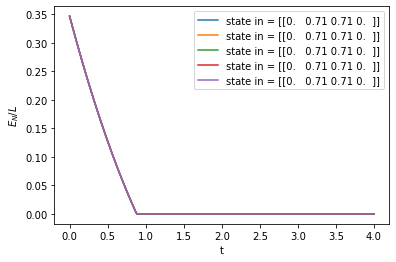

In [93]:
negativity(in_state = 1,lamb = 1,gamma_u = 1,gamma_d = 1,t_f = 4,t_steps = 200,disp=0);
negativity(in_state = 1,lamb = 0,gamma_u = 1,gamma_d = 1,t_f = 4,t_steps = 200,disp=0);
negativity(in_state = 1,lamb = 10,gamma_u = 1,gamma_d = 1,t_f = 4,t_steps = 200,disp=0);
negativity(in_state = 1,lamb = -1,gamma_u = 1,gamma_d = 1,t_f = 4,t_steps = 200,disp=0);
negativity(in_state = 1,lamb = -10,gamma_u = 1,gamma_d = 1,t_f = 4,t_steps = 200,disp=0);

### Peak width (lineal?) dependence on $\lambda$ for initial basis state

$\lambda = 1/2$

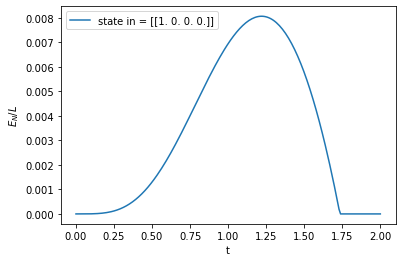

In [100]:
negativity(in_state = 0,lamb = 0.5,gamma_u = 1,gamma_d = 1,t_f = 2,t_steps = 200,disp=0);

$\lambda = 1$

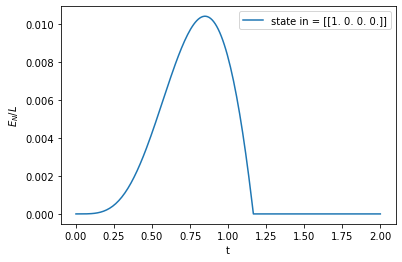

In [101]:
negativity(in_state = 0,lamb = 1,gamma_u = 1,gamma_d = 1,t_f = 2,t_steps = 200,disp=0);

$\lambda = 2$

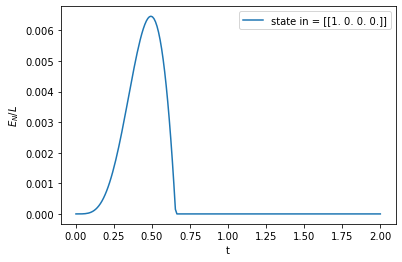

In [102]:
negativity(in_state = 0,lamb = 2,gamma_u = 1,gamma_d = 1,t_f = 2,t_steps = 200,disp=0);

**Notice also the slight dependence of the peak height on $\lambda$.**

### Peak height and width dependence on $\Gamma = \Gamma_u=\Gamma_d$ for initial basis state

$\Gamma = 1/2$

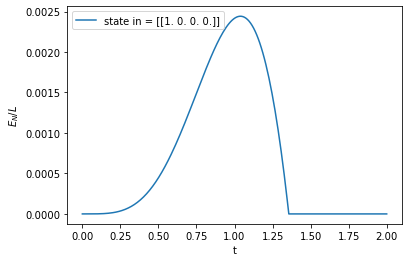

In [109]:
negativity(in_state = 0,lamb = 1,gamma_u = 0.5,gamma_d = 0.5,t_f = 2,t_steps = 200,disp=0);

$\Gamma = 1$

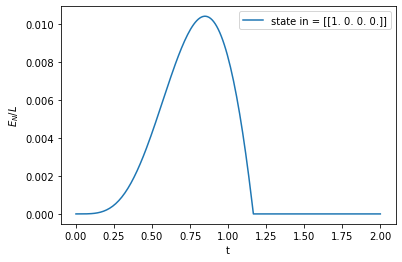

In [107]:
negativity(in_state = 0,lamb = 1,gamma_u = 1,gamma_d = 1,t_f = 2,t_steps = 200,disp=0);

$\Gamma = 2$

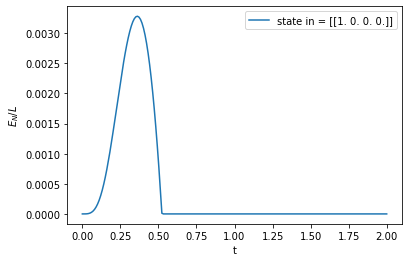

In [108]:
negativity(in_state = 0,lamb = 1,gamma_u = 2,gamma_d = 2,t_f = 2,t_steps = 200,disp=0);

**Notice also the dependence of the peak width on $\Gamma$.**

### Peak height and width dependence on $\Gamma_u \neq \Gamma_d$ for initial basis state

Here is where we see a big big height dependance

$\Gamma_u = 2, \Gamma_d = 2$

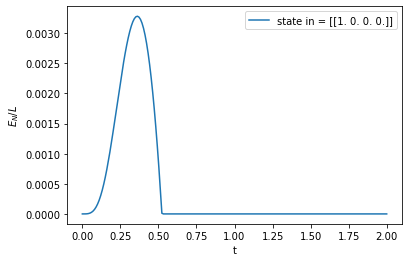

In [110]:
negativity(in_state = 0,lamb = 1,gamma_u = 2,gamma_d = 2,t_f = 2,t_steps = 200,disp=0);

$\Gamma_u = 2, \Gamma_d = 1$

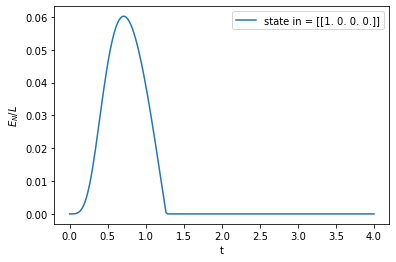

In [116]:
negativity(in_state = 0,lamb = 1,gamma_u = 2,gamma_d = 1,t_f = 4,t_steps = 200,disp=0);

$\Gamma_u = 2, \Gamma_d = 1/2$

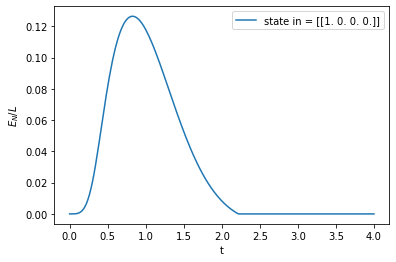

In [115]:
negativity(in_state = 0,lamb = 1,gamma_u = 2,gamma_d = 0.5,t_f = 4,t_steps = 200,disp=0);

$\Gamma_u = 2, \Gamma_d = 0$

The initial state is:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
The final state is:
[[0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.01+0.j   0.  -0.01j 0.  +0.j  ]
 [0.  +0.j   0.  +0.01j 0.01+0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.98+0.j  ]]
Other parameters:lamb = 1, Gamma_u = 2, Gamma_d = 0


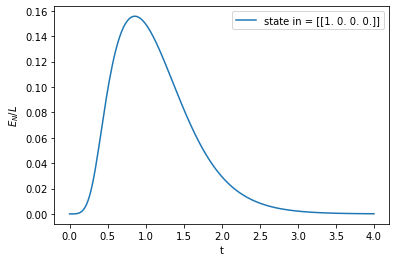

In [118]:
negativity(in_state = 0,lamb = 1,gamma_u = 2,gamma_d = 0,t_f = 4,t_steps = 200,disp=1);

Note the deseapperance of the apparent non smooth kink at the end of in the previous peak and compare it to the previous plots.

# Entanglement production mechanism

Take for instance the following parameters $\lambda = 1,\Gamma_u = 0, \Gamma_d = 2$ with initial density matrix
$$
\rho (t=0) = \begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 
\end{bmatrix}.
$$
We know that the final state must, and in fact is, given by
$$
\rho (t=\infty) = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 
\end{bmatrix},
$$
but in between there must be something else connecting the two states (smoothly). We see that near $t\sim 1$, approximately the middle of the peak, the density matrix is
$$
\rho (t = 1) = \begin{bmatrix}
    0.199 & 0 & 0 & 0 \\
    0 & 0.665 & 0.271 i & 0 \\
    0 & -0.271 i & 0.116 & 0 \\
    0 & 0 & 0 & 0.019 
\end{bmatrix},
$$
which is quite an entangled state, c.f. the cat state
$$
cat = \begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 1/2 & 1/2 & 0 \\
    0 & 1/2 & 1/2 & 0 \\
    0 & 0 & 0 & 0 
\end{bmatrix}.
$$
This makes sense: if we start at the basis state 
$$
\rho (t=0) = \begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 
\end{bmatrix},
$$
then the system has nothing to evolve (it's already its steady state) and it will remain like that forever without passing through any entangled states.

## State's matrix dynamics anymation

In [127]:
t_steps = 200
def negativity(in_state,lamb,gamma_u,gamma_d,t_f,t):
    H = lamb*(c(0).dag()*c(1)+c(1).dag()*c(0))
    
    V = [ket("00"),f_0.dag()*ket("00"),f_1.dag()*ket("00"),f_0.dag()*f_1.dag()*ket("00")]      # Eigenstates
    
    rho_0 = V[in_state]*V[in_state].dag()             # choose eigenstate
    
    c_ops = [gamma_d*c(0),gamma_u*c(0).dag()]         # Collapse operators affecting only first fermion

    time_array = np.linspace(0.0, t_f, t_steps)       # time array for numerical solver
    rho_t = mesolve(H, rho_0, time_array, c_ops)
    
    print(rho_t.states[t])
# warnings.filterwarnings('ignore')
interact(negativity, lamb=widgets.FloatSlider(value=1,min=-5,max=5,step=0.5), gamma_u=widgets.FloatSlider(value=1,min=0,max=10,step=0.5),gamma_d=widgets.FloatSlider(value=1,min=0,max=10,step=0.5),t_f=widgets.FloatSlider(value=4,min=1,max=10,step=0.1),in_state=widgets.IntSlider(value=2**L,min=0,max=4**L-1,step=1),t=widgets.IntSlider(value=0,min=0,max=t_steps-1,step=1));

interactive(children=(IntSlider(value=2, description='in_state', max=3), FloatSlider(value=1.0, description='l…